# About
Sentiment Detection using BERT in Tensorflow.


[Dataset Link](https://www.kaggle.com/pashupatigupta/emotion-detection-from-text)

In [52]:
#importing modules
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re

In [67]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/TwitterSentimentAnalysis')

In [68]:
#!unzip TextEmotion.zip

In [69]:
dataset = pd.read_csv('train.csv')

In [70]:
dataset.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [71]:
dataset.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [72]:
dataset.shape

(27481, 4)

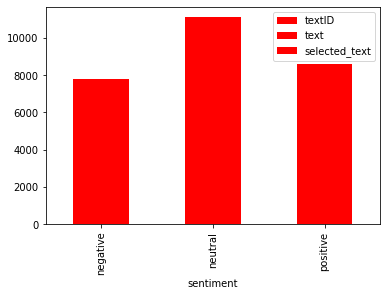

In [73]:
dataset.groupby('sentiment').count().plot.bar(color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


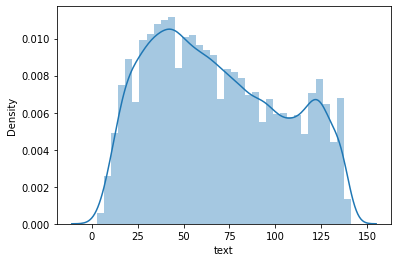

In [74]:
#plotting the distibution of number of characters in the tweets
sns.distplot(dataset.text.str.len())

In [75]:
#dropping unneccessary columns
dataset = dataset.drop(['textID', 'selected_text'],axis=1)
dataset.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [76]:
labels, features = [],[]
labels = pd.get_dummies(dataset['sentiment']).values
dataset =dataset.drop(['sentiment'], axis=1)
#converting to numerical
#converting content column in train and val set to text so as to convert any floating point/int content to str
features = dataset.text.astype(str).values


In [77]:
labels

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [78]:
features

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype=object)

In [79]:
# creating train and val_splits
X_train,X_val,y_train,y_val = train_test_split(features,labels, test_size=0.25)

In [80]:
print("Input training features and label shape are {},{}".format(X_train.shape,y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,y_val.shape))


Input training features and label shape are (20610,),(20610, 3)
Input validation features and label shape are (6871,), (6871, 3)


# Generating embedding using pre-trained BERT encoder i.e Fine-tuning phase.




In [81]:
# downloading tensorflow-text for preprocessing for BERT inputs
!pip install -q tensorflow-text
# For AdamW optimizer 
!pip install -q tf-models-official
# to create AdamW optimizer
from official.nlp import optimization  
import tensorflow_hub as hub
import tensorflow_text as text


In [21]:
bert_model_name_encoder = 'bert_en_uncased_L-12_H-768_A-12'
encoder_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_model_name_preprocess = 'bert_en_uncased_L-12_H-768_A-12'
preprocess_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [22]:
print(f'BERT model selected           : {encoder_download_link}')
print(f'Preprocess model auto-selected: {preprocess_download_link}')


BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [23]:
#loading bert_preprocessor and bert encoder
bert_preprocessor = hub.KerasLayer(preprocess_download_link, name='preprocessing')
bert_encoder = hub.KerasLayer(encoder_download_link, name='BERT_encoder')

In [82]:
#defining the model with few tweaks to original
def classifier_model():
  text_input = Input(shape =(), dtype= tf.string, name='text')
  #preprocesing layer
  preprocessed_text = bert_preprocessor(text_input)
  #passing through encoder layer
  embeddings = bert_encoder(preprocessed_text)
  #fetching the pooled_output from the dictionary of outputs
  output = embeddings['pooled_output']
  output = Dropout(0.2)(output)
  #passing through final dense layer with softmax
  output = Dense(3, activation=None, name='classifier_end')(output)
  return Model(text_input, output)
classifier = classifier_model()

In [83]:
classifier.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 109482241   preprocessing[3][0]              
                                                                 preprocessing[3][1]              
                                                                 preprocessing[3][2]              
____________________________________________________________________________________________

In [84]:
#defining the loss function
loss = CategoricalCrossentropy(from_logits=True)
metrics = CategoricalAccuracy()

In [86]:
steps_per_epoch =len(X_train)
num_train_steps = steps_per_epoch * 10
num_warmup_steps = int(0.01*num_train_steps)

init_lr = 1e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [87]:
#compiling the model
classifier.compile(optimizer = optimizer, loss=loss, metrics=metrics)

In [88]:
#fitting the model
history = classifier.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=50)

Epoch 1/50
645/645 [==============================] - 110s 167ms/step - loss: 1.3600 - categorical_accuracy: 0.3306 - val_loss: 1.0547 - val_categorical_accuracy: 0.4442
Epoch 2/50
645/645 [==============================] - 107s 166ms/step - loss: 1.0860 - categorical_accuracy: 0.4272 - val_loss: 0.9915 - val_categorical_accuracy: 0.4861
Epoch 3/50
645/645 [==============================] - 107s 166ms/step - loss: 1.0109 - categorical_accuracy: 0.4908 - val_loss: 0.9548 - val_categorical_accuracy: 0.5130
Epoch 4/50
645/645 [==============================] - 107s 165ms/step - loss: 0.9694 - categorical_accuracy: 0.5226 - val_loss: 0.9188 - val_categorical_accuracy: 0.5712
Epoch 5/50
645/645 [==============================] - 107s 166ms/step - loss: 0.9427 - categorical_accuracy: 0.5471 - val_loss: 0.8983 - val_categorical_accuracy: 0.5715
Epoch 6/50
645/645 [==============================] - 107s 165ms/step - loss: 0.9381 - categorical_accuracy: 0.5474 - val_loss: 0.9151 - val_categoric

In [91]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

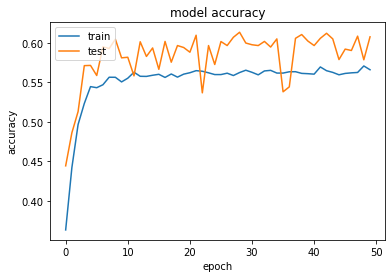

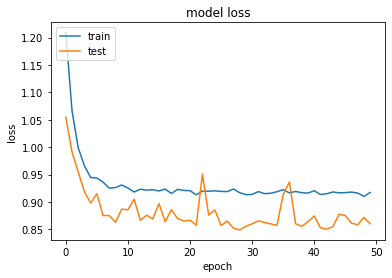

In [92]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
#saving model
classifier.save('trained_BERT_Classifier.h5')

In [103]:
test_string1 = ["I am afraid that I won't be available on call tommorow!"]
test_string2 = ["This is an awesome course, I loved it"]
def predict(test_string):
  class_prob = classifier.predict(test_string, batch_size=1)[0]
  if np.argmax(class_prob)==0:
    print("Negative Sentiment")
  elif np.argmax(class_prob)==1:
    print("Neutral Sentiment")
  else:
    print("Positive Sentiment")
  
predict(test_string1)
predict(test_string2)

Negative Sentiment
Positive Sentiment
